# This notebook is concerned with handling Item Name

# Table of contents
- [Overview](#overview)
    - [We'll be dealing with](#well-be-dealing-with)
    - [Approach](#approach)
- [Setup and load data](#setup-and-load-data)
- [Handling Item Names](#Handling-Item-Names)
    - [Normalization and lemmatization](#normalization-and-lemmatization)
        - [Character level normalization](#character-level-normalization)
        - [Word level normalization and lemmatization](#word-level-normalization-and-lemmatization)
        - [Normalized and Disjointed cols created](#normalized-and-disjointed-cols-created)
    - [Arabic lexicon](#string-tokens)
        - [Create lexicon](#create-lexicon)
        - [Analyze lexicons' word frequency](#analyze-lexicons-word-frequency)
        - [Manual cleaning of edge cases in lexicon](#manual-cleaning-of-edge-cases-in-lexicon)
    - [Combine disjointed letters](#Combine-disjointed-letters)
        - [Research findings](#Research-findings)
        - [🚨 ***Trie and Viterbi Segment technique***](#Trie-and-Viterbi-segment-technique)
            - [Algorithm](#algorithm)
                - [Notes (the key decisions in implementing the algorithm)](#Notes-(the-key-decisions-in-implementing-the-algorithm))
                - [A few tests](#a-few-tests)
        - [Rejoining the disjointed letters](#Rejoining-the-disjointed-letters)
            - [Rejoined column created](#rejoined-column-created)
            - [Combined column created](#combined-column-created)
    - [Analyze tokens](#Analyze-tokens)
        - [Token lengths](#token-lengths)
        - [Clean Combined Column](#clean-combined-column)
        - [Save preprocessed Item Name](#save-preprocessed-item-name)
    - [Embed tokens](#embed-tokens)
        - [Compare current vocab with FastText's](#compare-current-vocab-with-fasttexts)
- [Categorize preprocessed Item Names](#Categorize-preprocessed-Item-Names)
    - [BERTopic](#BERTopic)
    - [Manual renaming of topics](#Manual-renaming-of-topics)
- [Appendix](#Appendix)
    - [Tests - for myself](#tests)

# Overview


## We'll be dealing with: 


- a mix of Arabic and English entries,
- item codes/numerical values,
- and lack of clear categorization.

## Approach:


1. Normalization and lemmatization
    - normalize characters
    - Remove unnecessary chars/symbols/units/fillers
    - lemmatization
    - break corpus into string tokens
3. Generate Arabic lexicon from whole words
    - Calculate unigram probability + Laplace Smoothing 
4. Combine disjointed letters into full words based on the lexicon
    - Trie (data structure) + Viterbi Segment technique (dynamic programming)
5. Analyze tokens in the data
6. Categorize processed Item Names
    - We'll use BERTopic to find the categories as a category agnostic approach
    - Then we'll manually rename the categories to more interpretable titles
7. Spend analysis-ready

# Setup and load data

In [135]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from math import log

from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants: أ إ آ -> ا
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar,    # ة -> ه or keep ة depending on needs
    normalize_unicode            # Normalize Unicode strings into their canonically composed form
)
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

import re
import unicodedata
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan

In [74]:
data_path = "../data/cleaned_num.xlsx"
df_original = pd.read_excel(data_path)
df = df_original.copy()

# For now we just care about Item Name
df = df[['Item Name']]

# Handling Item Names

## Normalization and lemmatization
Using CAMeL-Tools since it handles both Arabic and English texts

### Character level normalization

In [75]:
_EXTRA_TRANSLATE = {
    ord('ی'): ord('ي'),   # Farsi Yeh → Arabic Yeh
    ord('ـ'): None,       # Tatweel (kashida) → remove
}

def normalize_text(text: str) -> str:
    # Stronger Unicode compat normalization
    text = unicodedata.normalize('NFKC', text)

    # Existing CAMeL steps
    text = text.lower()
    text = normalize_unicode(text)
    text = dediac_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = text.translate(_EXTRA_TRANSLATE)

    return text.strip()


In [76]:
# Let's see the results - yes I noticed some entries are split (like 1563) which really gave me a headache trying to solve lol
df.iloc[[439, 743, 901, 1563]]

,Item Name
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر
743,كيس مادة
901,GATE BARIAR PANEL2
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ


### Word level normalization and lemmatization

In [77]:
# Cell for lists of dimension/units, protected words, and AR stop words
# List 1: English unit tokens (lowercase; include singular/plural + common abbrevs)
UNIT_TOKENS_EN = {
    "x",
    # length
    "mm","millimeter","millimeters","millimetre","millimetres",
    "cm","centimeter","centimeters","centimetre","centimetres",
    "m","meter","meters","metre","metres", "mtr", "unit",
    "km","kilometer","kilometers","kilometre","kilometres",
    "in","inch","inches",
    "ft","foot","feet",
    "yd","yard","yards",
    "mi","mile","miles",
    # mass
    "g","gram","grams","gramme","grammes",
    "mg","milligram","milligrams","milligramme","milligrammes",
    "kg","kilogram","kilograms","kilogramme","kilogrammes",
    "t","ton","tons","tonne","tonnes",
    "oz","ounce","ounces",
    "lb","lbs","pound","pounds","st","stone","stones",
    # volume
    "l","liter","liters","litre","litres",
    "ml","milliliter","milliliters","millilitre","millilitres",
    "cl","centiliter","centiliters","centilitre","centilitres",
    "dl","deciliter","deciliters","decilitre","decilitres",
    "cc"
}

# List 2: Arabic unit tokens (normalized, no spaces)
UNIT_TOKENS_AR = {
    # length
    "مم","ملم","مليمتر","مليمترات","ملليمتر","ملليمترات",
    "سم","سنتمتر","سنتيمتر","سنتيمترات","سنتمترات",
    "م","متر","أمتار", "مت"
    "كم","كلم","كيلومتر","كيلومترات",
    "إنش","انش","بوصة","بوصات",
    "قدم","أقدام",
    "ياردة","ياردات",
    "ميل","أميال",
    # mass
    "غ","جم","جرام","جرامات","غرام","غرامات",
    "ملغ","مغ","مجم","ميليغرام","ميليجرام","ميليغرامات","ميليجرامات","مليغرام","مليجرام",
    "كغ","كجم","كيلوغرام","كيلوجرام","كيلوغرامات","كيلوجرامات","كيلو",
    "طن","أطنان",
    "أونصة","أونصات","اوقية","أوقية","أوقيات",
    "رطل","أرطال",
    # volume
    "لتر","لترات",
    "ملي","مل","ميليلتر","مليلتر","ميليلترات","مليلترات",
    "سنتيلتر","سنتيلترات","ديسيلتر","ديسيلترات",
    # keywords
    'مقاس', 'سماكه', 'طول'
}
UNIT_TOKENS_AR = [normalize_text(t) for t in UNIT_TOKENS_AR]

protected_words = ["سابك"]

with open('../assets/AR_stop_words.txt', encoding='utf-8') as f:
    AR_STOP = set(normalize_text(line.strip()) for line in f if line.strip())

In [78]:
# Disambiguator and Morphological Tokenizer modules from CAMel-Tools to help with normalizion and lemmatization
mle = MLEDisambiguator.pretrained('calima-msa-r13')
tokenizer = MorphologicalTokenizer(disambiguator=mle, scheme='d3tok', split=True, diac=False)

In [79]:
# Now we'll normalize the text further to ensure we only have Arabic and English characters

def is_arabic_char(c: str) -> bool:
    return '\u0600' <= c <= '\u06FF'

def is_english_char(c: str) -> bool:
    return c.isascii() and c.isalpha()

def keep_arabic_english_only(c: str) -> str:
    if (is_arabic_char(c) or is_english_char(c)) and not c.isdigit():
        return c
    return " "  # replace everything else with space

def preprocess_text(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)
    
    # 3) Split on whitespace
    tokens = text.split()

    # 4) Extra cleaning steps for lexicon
    if no_disjointed:
        # 4.1) Remove dimensions/units/fillers for lexicon
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and t not in UNIT_TOKENS_AR and t not in AR_STOP]
    
        # 4.2) Lemmatize and remove clitics for lexicon
        tokens = [t if t in protected_words else ''.join(normalize_text(p) for p in tokenizer.tokenize([t]) if '+' not in p) 
          for t in tokens]
    
        # 4.3) Drop single-letter tokens, and deduplicate within the row for lexicon
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        seen = set()
        tokens = [t for t in tokens if not (t in seen or seen.add(t))]
        return ' '.join(tokens)
    
    # 5) Or retain only the disjointed letters to glue back later
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)

In [80]:
# Some tests to see the results of normalization
text_test1 = "سماكه حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات"
print("Before normalization:", text_test1)
print("After normalization:", preprocess_text(text_test1))

print("-----------------")

text_test2 = "ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ"
print("Disjoint - before:", )
print("Disjoint - after:", preprocess_text(text_test2, no_disjointed=False))

Before normalization: سماكه حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات
After normalization: حديد تسليح مجدول سعودي سابك مخططات
-----------------
Disjoint - before:
Disjoint - after: حديدمجدولسابكملممترسعودي


#### Normalized and Disjointed cols created

In [81]:
df["Normalized"] = '' # Default to ''
df["Normalized"] = (df["Item Name"].apply(preprocess_text, no_disjointed=True)).str.strip()

# Disjointed cols is only concerned with Arabic rows where the normalization wasn't fruitful (i.e. disjointed letters)
df["Disjointed"] = ''
mask = (df["Normalized"] == '') & ~df["Item Name"].apply(lambda s: all(is_english_char(c) for c in str(s) if c.isalpha()))
df.loc[mask, "Disjointed"] = df.loc[mask, "Item Name"].apply(
    preprocess_text, no_disjointed=False 
).str.strip()

In [82]:
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,
743,كيس مادة,كيس ماده,
901,GATE BARIAR PANEL2,gate bariar panel,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت


Good, now we have normalized Arabic and English words, but also the disjointed chars are saved for later

## Arabic lexicon

### Create lexicon

In [83]:
corpus = df['Normalized']
tokens = [simple_word_tokenize(text) for text in corpus]

In [84]:
len(tokens)

3150

In [85]:
# Lexicon is in Arabic, so we'll remove english for now
def is_arabic(token):
    return bool(re.search(r'[\u0600-\u06FF]', token))

arabic_tokens = [tok for row in tokens for tok in row if is_arabic(tok)]
lexicon = Counter(arabic_tokens)

In [86]:
# How many words did we get?
lexicon.__len__()

646

In [87]:
# Let's quickly check the most frequent words used
lexicon.most_common(20)

[('حديد', 564),
 ('تسليح', 316),
 ('سابك', 212),
 ('اسود', 142),
 ('صاج', 126),
 ('اتفاق', 90),
 ('ماسوره', 73),
 ('وطني', 58),
 ('سلك', 54),
 ('سعودي', 53),
 ('توريد', 46),
 ('مجدول', 40),
 ('راجحي', 38),
 ('ويل', 33),
 ('كيبل', 32),
 ('سويدي', 29),
 ('مسحوب', 25),
 ('مجلفن', 25),
 ('املس', 21),
 ('الواح', 20)]

### Analyze lexicons' word frequency

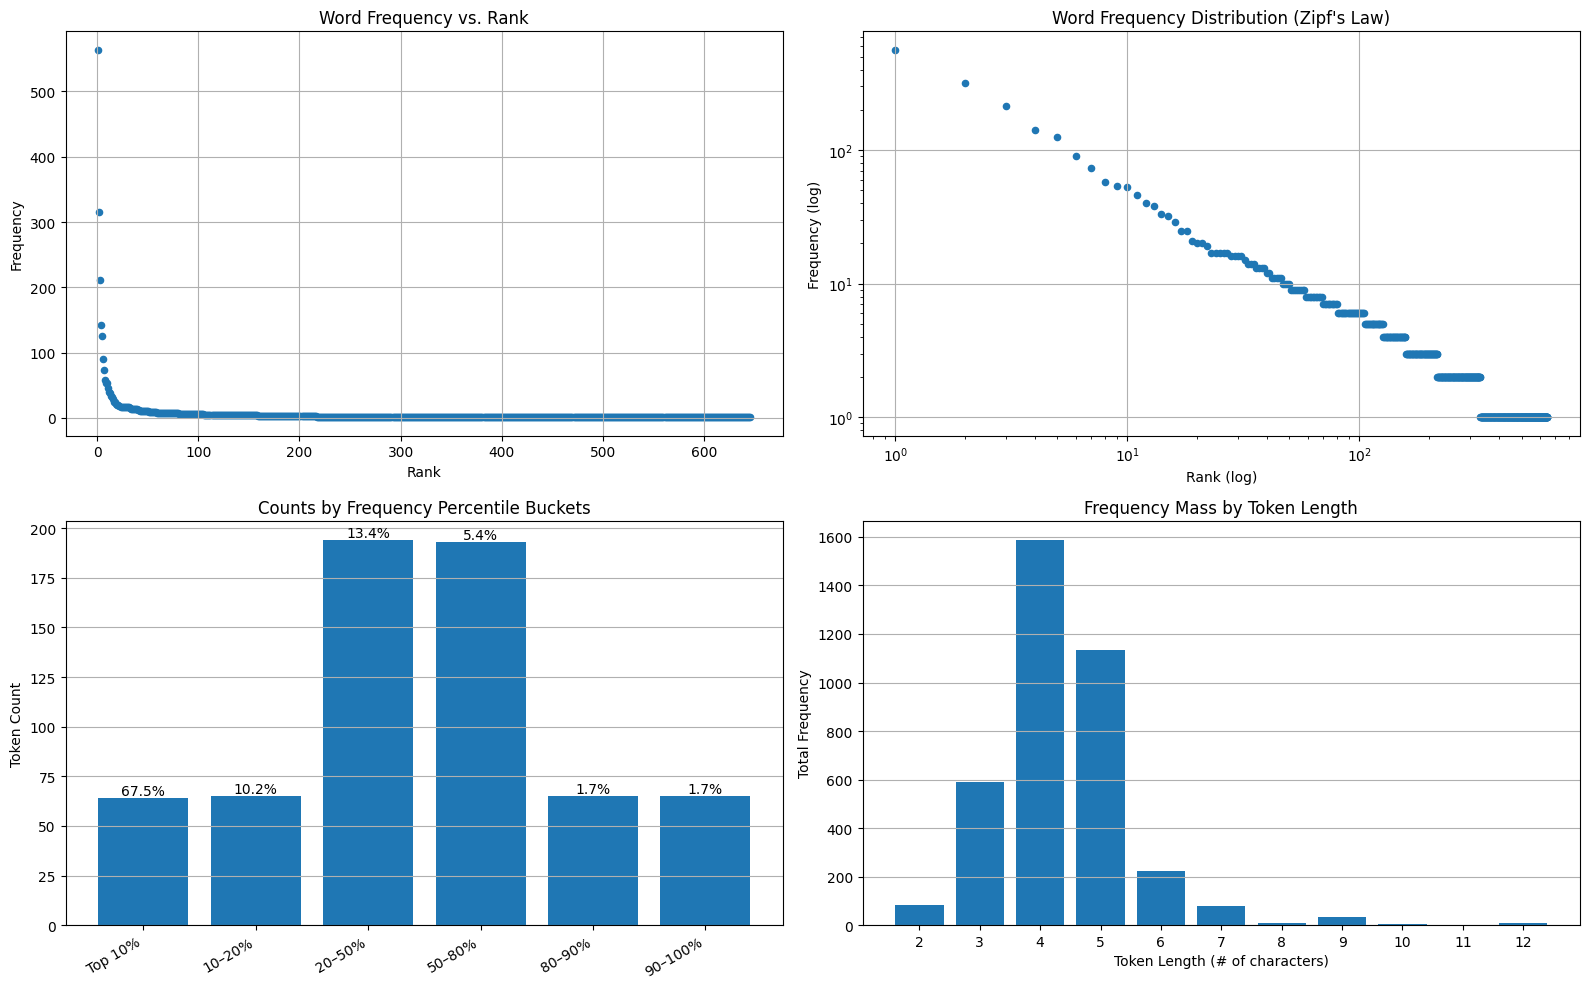

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Sort frequencies descending
freqs_sorted = np.array(sorted(lexicon.values(), reverse=True))
ranks = np.arange(1, len(freqs_sorted) + 1)

# -- precompute percentile buckets (by rank)
N = len(freqs_sorted)
pct_edges = [0, 10, 20, 50, 80, 90, 100]  # buckets: Top10, 10–20, 20–50, 50–80, 80–90, 90–100 (tail)
idx_edges = [int(np.floor(p/100 * N)) for p in pct_edges]
labels = [f"Top {pct_edges[1]}%"] + [f"{pct_edges[i]}–{pct_edges[i+1]}%" for i in range(1, len(pct_edges)-1)]

bucket_counts = []
bucket_mass_share = []
total_mass = freqs_sorted.sum()
for i in range(len(idx_edges)-1):
    lo, hi = idx_edges[i], idx_edges[i+1]
    cnt = max(hi - lo, 0)
    bucket_counts.append(cnt)
    mass = freqs_sorted[lo:hi].sum() if cnt > 0 else 0
    bucket_mass_share.append(100.0 * mass / total_mass if total_mass > 0 else 0.0)

# --- length histogram (1-char, 2-char, 3-char, ...) weighted by frequency
length_mass = {}
for token, c in lexicon.items():
    L = len(token)
    length_mass[L] = length_mass.get(L, 0) + c
lengths = np.array(sorted(length_mass.keys()))
length_counts = np.array([length_mass[L] for L in lengths])

# ---- 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) Simple scatter plot (rank vs frequency)
axes[0, 0].scatter(ranks, freqs_sorted, s=20)
axes[0, 0].set_xlabel("Rank")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Word Frequency vs. Rank")
axes[0, 0].grid(True)

# 2) Zipf's Law (log-log)
axes[0, 1].scatter(ranks, freqs_sorted, s=20)
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Rank (log)")
axes[0, 1].set_ylabel("Frequency (log)")
axes[0, 1].set_title("Word Frequency Distribution (Zipf's Law)")
axes[0, 1].grid(True)

# 3) Percentile bucket counts
x = np.arange(len(labels))
axes[1, 0].bar(x, bucket_counts)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, rotation=30, ha="right")
axes[1, 0].set_ylabel("Token Count")
axes[1, 0].set_title("Counts by Frequency Percentile Buckets")
axes[1, 0].grid(True, axis="y")
# annotate each bar with its mass share
for i, (xc, cnt, mass_pct) in enumerate(zip(x, bucket_counts, bucket_mass_share)):
    if cnt > 0:
        axes[1, 0].text(xc, cnt, f"{mass_pct:.1f}%", ha="center", va="bottom")

# 4) Length histogram (frequency-weighted)
axes[1, 1].bar(lengths, length_counts, width=0.8)
axes[1, 1].set_xticks(lengths)
axes[1, 1].set_xlabel("Token Length (# of characters)")
axes[1, 1].set_ylabel("Total Frequency")
axes[1, 1].set_title("Frequency Mass by Token Length")
axes[1, 1].grid(True, axis="y")

plt.tight_layout()
plt.show()


#### **Plots 1 & 2**

This might be an extreme case of Zipf's law, but the frequency of the word is strongly inversely related to its rank

Nonetheless, when reconstructing the words from the disjoint words, we'll ensure that we give more frequent words more weight, sort of a probabilistic approach. The priors being the frequency of the term in the lexicon relative to the other terms.

#### **Plot 3**

The top 10% most frequent tokens appear in 67.6% of the normalized corpus. Whereas the bottom 30% tokens appear in less than 10% of the corpus. To be cautious but also remove things that are less frequent, we'll remove the buttome 10% of tokens. 

In [89]:
# Just to be sure let's see some of those buttom 10%
items_sorted = sorted(lexicon.items(), key=lambda x: x[1])  
N = len(items_sorted)

# Bottom 10% by rank
pct = 10
cutoff_idx = min(int(np.ceil(pct / 100 * N)), 15)
bottom_10 = items_sorted[:cutoff_idx]

print(f"Bottom {pct}% tokens by rank (capped at 15 tokens):")
for token, freq in bottom_10:
    print(f"{token}: {freq}")

Bottom 10% tokens by rank (capped at 15 tokens):
مبسط: 1
برونزالفاء: 1
اماراتي: 1
هان: 1
رويال: 1
حليب: 1
سوبر: 1
سمارت: 1
ريمون: 1
موديل: 1
برنزالفاء: 1
سيليكون: 1
اكر: 1
طبشه: 1
درفه: 1


The words appear to be meaningful, so we'll not drop any.

#### **Plot 4**

Most words fall within 3 and 7 characters. Let's see some examples of the extremes at 2 chars and >=9 chars long:

In [90]:
{k: v for k, v in lexicon.items() if len(k) == 2}

{'رش': 4,
 'شب': 9,
 'دن': 1,
 'حر': 11,
 'سد': 8,
 'اي': 5,
 'لب': 3,
 'خط': 1,
 'حب': 1,
 'كل': 1,
 'يا': 1,
 'ات': 11,
 'تر': 1,
 'جد': 3,
 'يد': 2,
 'ين': 1,
 'نص': 1,
 'يخ': 5,
 'جي': 1,
 'دي': 2,
 'شر': 1,
 'ال': 1,
 'خا': 1,
 'قص': 5,
 'سن': 1,
 'صب': 1,
 'مت': 2}

In [91]:
{k: v for k, v in lexicon.items() if len(k) >= 9}

{'برونزالفاء': 1,
 'برنزالفاء': 1,
 'المستعماره': 2,
 'بوصهبلاستيك': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'الابعادpanel': 8,
 'والقسامات': 1,
 'واالكسسوارات': 1,
 'ايزوبروبيل': 1,
 'حديدتسليح': 4,
 'استتواريو': 1}

There is a mix between words that are uninterpretable and ones that are not. Unfortunately this may be a byproduct of the CAMel-tools tokenizer-disambiguator combo, which was our only efficient hope of normalizing and lemmatizing the tokens. Hence, this approach will suffice for now. More efforts could be shed on improving the normalization phase so we can further optimize the lexicon.

**Note:** I'll manually clean these tokens to improve our lexicon.

### Manual cleaning of edge cases in lexicon

In [92]:
# Extract and remove tokens surgically
extract_map = {
    'الابعادpanel': ['الابعاد', 'panel'],
    'بوصهبلاستيك': ['بلاستيك'],
    'واالكسسوارات': ['اكسسوارات'],
    'برونزالفاء': ['برونز'],
    'برنزالفاء': ['برونز'],
    'والقسامات': ['قسامات'],
    'حديدتسليح': ['حديد','تسليح'],
}

# Apply extractions
for src, parts in extract_map.items():
    if src in lexicon:
        for p in parts:
            p = preprocess_text(p)
            if p in lexicon:
                lexicon[p] += 1
            else:
                lexicon[p] = 1
        lexicon.pop(src, None)

remove_words = {
    'شب','دن','حر','اي','لب','حب','كل','يا','ات','تر','جد','يد','ين','يخ','جي','دي','شر','ال','خا','سن','مت', 'نص',
    'استتواريو', 'المستعماره'
}

for bad in remove_words:
    lexicon.pop(bad, None)

{k: v for k, v in lexicon.items() if len(k) >= 9 or len(k) == 2}

{'رش': 4,
 'سد': 8,
 'اكسسوارات': 9,
 'الخرسانيه': 17,
 'خط': 1,
 'ايزوبروبيل': 1,
 'قص': 5,
 'صب': 1}

## 

## Combine disjointed letters
Combining the letters based on the lexicon is only one half of the solution, the harder part is understanding the boundaries of words where letters are disjointed and ambiguous.

### Research findings


This problem could be cut in three parts:
1. Find unigram probability for each lexicon entry
    - We don't have a large enough corpus to use ngrams, plus we don't know the boundaries of words
2. Create a Trie data structure from the lexicon
3. Traverse the Trie and determine the word with most likelihood
    - We could go about the traversal using a greedy approach, which means looking at each word in the sentence alone, but I've decided to follow a better approach (Viterbi algo.) which looks at how the words fit in a sentance

### ***Trie and Viterbi Segment technique***

#### Algorithm

In [93]:
# Node definition for the Trie
class TrieNode: 
    __slots__ = ("ch","end","logp")
    def __init__(self):
        self.ch = {} # Children nodes dictionary
        self.end = False # Boolean: node marks a word's end
        self.logp = float("-inf") # Likelihood for this word, only relevant if end is True 

# Trie structure to hold the lexicon
class Trie:
    def __init__(self):
        self.root = TrieNode()
    def insert(self, word, logp): # Insert a node in the Trie
        node = self.root
        for c in word:
            node = node.ch.setdefault(c, TrieNode()) # If there's a node for c return it, else create a new node for c
        node.end = True
        node.logp = logp
    def in_trie_prefix(self, s): # Checks if the string/word is in our Trie
        node = self.root
        for ch in s:
            if ch not in node.ch:
                return False
            node = node.ch[ch]
        return node.end

# The blueprint to creating the Trie DS
def build_trie_from_counts(counts, alpha=0.0):
    # counts: dict[word] -> int
    V = len(counts) # Vocabulary size
    Z = sum(counts.values()) + alpha * V # Denominator = N_train (total no. of words) + weighted V
    T = Trie()
    for w, c in counts.items():
        p = (c + alpha) / Z
        T.insert(w, log(p))
    return T

def viterbi_segment(chars, trie, del_char_logp=log(6.7e-3)): # ≈ -5.00
    """chars: e.g. 'catsanddog' (spaces removed). Returns words and score."""

    if chars == "":
        return "", 1
    
    n = len(chars)
    best = [float("-inf")] * (n + 1)
    back = [None] * (n + 1) # (end of word index for word starting at i: int, start of a word: boolean)
    best[n] = 0.0  # empty suffix has score 0

    # This loop begins at the end of the sentence, to evaluate all possible word formations taking into account the entire sentence
    for i in range(n - 1, -1, -1): 
        node = trie.root
        j = i
        while j < n and chars[j] in node.ch: # Check if the char exists in the children of the current node
            node = node.ch[chars[j]] # Look at the branch associated with chars[j]
            j += 1
            if node.end: # If chars[i:j] completes a word, then step in
                cand = node.logp + best[j] # The core of the Viterbi DP; considers likelihood of chars[i:j] and even chars[j:] 
                if cand > best[i]:
                    best[i] = cand
                    back[i] = (j, True)
        
        # Mark char position as a skip when it doesn't form a word and propagate logp.
        # This helps when the end of the sentence isn't found in lexicon/Trie.
        # The del_char_logp is added to penalize skipping characters
        cand_skip = best[i+1] + del_char_logp  
        if cand_skip > best[i]:
            best[i] = cand_skip
            back[i] = (i+1, False)

    # Reconstruct the words
    words = []
    i = 0
    while i < n:
        j, is_word = back[i]
        if is_word: # i.e. character at i isn't marked as skip
            words.append(chars[i:j])
        i = j

    
    
    if len(words) == 1: # Sometimes we'll only recognize one word; let's flag the case with 1
        return words, 1
    
    elif not words: # In case we failed to construct any words; flag with 0
        return "unknown", 0
    
    else: # We found a list of words; return the score (<0) and join by space later to reconstruct sentence
        return words, best[0]

##### Notes (the key decisions in implementing the algorithm)


- **Scoring**
  
  - Use natural-log probabilities: `node.logp = log p(w) ≤ 0`.  
  - Base case: `best[n] = 0.0` (log 1). A fallback case when no words are found.

- **Transitions at position i**
  
  - **Words:** for each trie end at `j`, candidate = `node.logp + best[j]`.  
  - **Skip 1 char:** candidate = `best[i+1] + del_char_logp`. Always include it as a competitor (not just a fallback).

- **Skip penalty**
  
  - Set `del_char_logp = log(p_del)` with `0 < p_del << 1` (same log base).  
  - Example: `del_char_logp = log(6.7e-3) ≈ -5.0`.  

- **Decision intuition (per-char threshold)**
  
  - Word of length `L` beats skipping those `L` chars iff  
    `log P(w) > L * del_char_logp` ⇔ `(log P(w))/L > del_char_logp`.  
  - So `del_char_logp` acts as a per-character quality threshold.

- **Correction to earlier intuition**
  
  - Choosing a word at `[i:j)` does **not** force later scores below `best[j+1]`.  
  - With a **negative** skip penalty, a strong word can outperform a run of skips by avoiding `L * |del_char_logp|`.

- **Bias toward frequent words**
  
  - Already handled by larger (less negative) `log P(w)`.  
  - Tune `del_char_logp` to trade off segmentation vs. deletions; already tried multiple hyperparamters.

##### A few tests


In [94]:
# Toy example
counts = {
    "cat": 40, "cats": 30, "sand": 5, "and": 20, "an": 25, "dog": 70
}
trie = build_trie_from_counts(counts, alpha=1.0)
words, score = viterbi_segment("catsanddogfiller", trie)
print(words)  # e.g., ['cats', 'and', 'dog'] 


['cats', 'and', 'dog']


In [95]:
# Examples from our data

trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[1563], trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج', 'اسود'] -26.945972962459084


In [96]:
trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[2833], trie_ar)
print(df["Disjointed"].iloc[2833])
print(words, score)

حديدمجدولاتفاقملممترسعود
['حديد', 'مجدول', 'اتفاق'] -60.58907237768291


In [97]:
print("سماكه in trie?", trie_ar.in_trie_prefix("سماكه"))

سماكه in trie? False


In [98]:
print("مجدول in trie?", trie_ar.in_trie_prefix("مجدول"))

مجدول in trie? True


### Rejoining the disjointed letters
Now we can reconstruct the disjointed letters in the Item Name column

In [99]:
def segment_and_join(text, trie):
    words, score = viterbi_segment(text, trie)
    
    # Catch edge cases
    if score == 0 or score == 1:
        return words
    
    # Join words with spaces
    else: 
        return " ".join(words)

#### Rejoined column created

In [100]:
df["Rejoined"] = ''
df["Rejoined"] = (df["Disjointed"].apply(lambda t: segment_and_join(t, trie_ar))).str.strip()

In [101]:
# Let's see the results
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed,Rejoined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,,
743,كيس مادة,كيس ماده,,
901,GATE BARIAR PANEL2,gate bariar panel,,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود


In [102]:
df["Rejoined"].iloc[2833]

'حديد مجدول اتفاق'

#### Combined column created

In [103]:
# Now let's add a new fully preprocessed column
df["Combined"] = (
    df["Normalized"].fillna("").str.strip() + " " + df["Rejoined"].fillna("").str.strip()
).str.strip()
df.iloc[[439, 743, 901, 1563, 1663]]

,Item Name,Normalized,Disjointed,Rejoined,Combined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,,,تيوب المنيوم مستطيل
743,كيس مادة,كيس ماده,,,كيس ماده
901,GATE BARIAR PANEL2,gate bariar panel,,,gate bariar panel
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود,صاج اسود
1663,XT1N 160 TMD 40-450 3p F F,xt tmd,,,xt tmd


In [104]:
df_test = df[df["Disjointed"] != ""]
df_test.to_excel("../data/reconstructed_entries.xlsx")
df_test.head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined
1562,ﺻ ﺎ ﺝ ﺍ ﺳ و د 1220 * 2440 * 20 ﻣ ﻠ,,صاجاسودمل,صاج اسود,صاج اسود
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود,صاج اسود
1565,ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 5 ﺑ و ﺻ ﺔ * 4.0 ﻣ ﻝ 12 ﻣ ﺗ ﺭ,,ماسورهاسودبوصهملمتر,ماسوره اسود,ماسوره اسود
1566,ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 5 ﺑ و ﺻ ﺔ * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ,,ماسورهاسودبوصهملمتر,ماسوره اسود,ماسوره اسود
1567,ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ,,تيوبفارغمربعملمتر,تيوب فارغ مربع,تيوب فارغ مربع


## Analyze tokens

### Token lengths

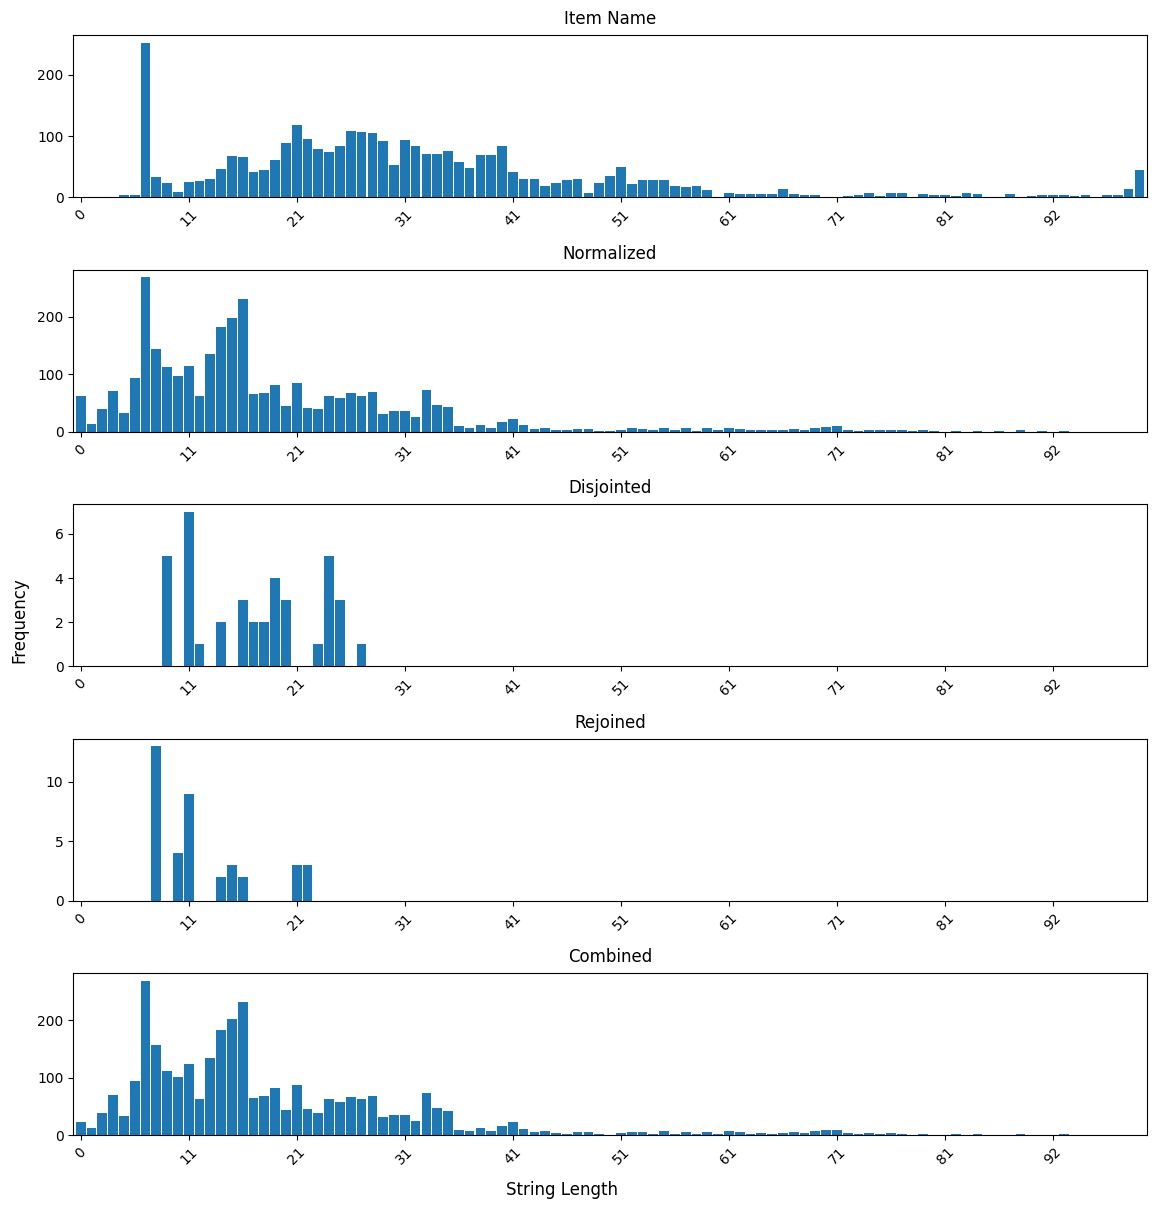

In [105]:
# Visualize the character lengths per preprocessing stage

# Columns where zero-length is an artifact you'd like to ignore
drop_zero_len_cols = {"Disjointed", "Rejoined"}

length_counts = {}
for col in df.columns:
    lengths = df[col].astype(str).str.len()
    if col in drop_zero_len_cols:
        lengths = lengths[lengths > 0]  # drop zeros only for these columns
    length_counts[col] = lengths.value_counts().sort_index()

# Put into a DataFrame (rows = lengths, columns = original columns)
length_counts_df = pd.DataFrame(length_counts).fillna(0).astype(int)

# Plot histograms per column with cleaner style
fig, axes = plt.subplots(len(length_counts_df.columns), 1, figsize=(12, 2.5*len(length_counts_df.columns)), sharex=False)

for ax, col in zip(axes, length_counts_df.columns):
    length_counts_df[col].plot(kind="bar", ax=ax, width=0.9)
    ax.set_title(col, fontsize=12, pad=8)
    
    # Show only ticks at 0, 10, 20, ... up to 100
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Rotate x labels for readability
    ax.tick_params(axis="x", rotation=45)

# Global x label
fig.text(0.5, 0.04, "String Length", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [106]:
df[df["Combined"] == ""].head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined
1675,S201-C10,,,,
1676,S203-C6,,,,
1681,S203-C63,,,,
1697,S201-C16,,,,
1698,S202-C10,,,,


After normalization many of the original Item Names shrunk down as a result of removing digits, untis, etc., while some empty rows arose as a result of cleaning disjoint letters. 

Disjointed and Rejoined also exhibit a similar trend. To clear something first, the plot shows only the rows where there were values (disjoint letters). Overall, the sentence legnths shrunk due to some words found in the respective rows not being present in the lexicon. However, we can clearly see that no rows were completely eliminated; we successfully brought back some context from the disjoint letters.

Lastly, the combined letters match the distribution of the normalized column. This is normal as we only added 39 rows from Rejoined, and that didn't change the distrubution by much.

All in all. Most rows have at least a few characters/words that we could extract the context of the purchase from. Notably, there are some 0-char rows in Combined which are English entries (e.g., S201-C10) where digits and symbols were removed and letters were left disjoint. We'll work on cleaning these now.

### Clean Combined column

#### Entries with <= 2 chars

In [107]:
# Let's see the combined Item Names with <= 2 chars
df[df["Combined"].str.len() <= 2]

,Item Name,Normalized,Disjointed,Rejoined,Combined
1497,DP 25CM*40CM*2M D20,dp,,,dp
1498,DP 30CM*40CM*2M D20,dp,,,dp
1499,DP 25CM*40CM*40CM D20,dp,,,dp
1659,GI 0.60X1219X2440MM,gi,,,gi
1660,GI 0.80X1219X2440MM,gi,,,gi
1661,GI 1.00X1219X2440MM,gi,,,gi
1662,GI 0.70X1219X2440MM,gi,,,gi
1675,S201-C10,,,,
1676,S203-C6,,,,
1681,S203-C63,,,,


It appears that some Item Names were recorded only as their common code names. No description provided about what the product is. For such cases I'll manually populate `Combined` with the code names for these entries. We can see that the first word in Item Name effectively captures most of the knowledge we could get of each item.

In [108]:
# Assign first word of "Item Name" where mask is True
mask = df["Combined"].astype(str).str.len() <= 2
df.loc[mask, "Combined"] = df.loc[mask, "Item Name"].str.split().str[0]

In [109]:
df[mask]

,Item Name,Normalized,Disjointed,Rejoined,Combined
1497,DP 25CM*40CM*2M D20,dp,,,DP
1498,DP 30CM*40CM*2M D20,dp,,,DP
1499,DP 25CM*40CM*40CM D20,dp,,,DP
1659,GI 0.60X1219X2440MM,gi,,,GI
1660,GI 0.80X1219X2440MM,gi,,,GI
1661,GI 1.00X1219X2440MM,gi,,,GI
1662,GI 0.70X1219X2440MM,gi,,,GI
1675,S201-C10,,,,S201-C10
1676,S203-C6,,,,S203-C6
1681,S203-C63,,,,S203-C63


Almost didn't catch the issue in row 2015. We'll replace with unkown since it's just dimensions

In [110]:
df.loc[2015, "Combined"] = "unknown"

### Before and after processing

In [111]:
# Let's see how many unique rows we've got
print("Number of unique rows before cleaning:", df["Item Name"].nunique())
print("Number of unique rows after cleaning:", df["Combined"].nunique())

print("-------------------------------------")

# Let's see how many unique words we've got
words_before = set(" ".join(df["Item Name"]).split())
words_after = set(" ".join(df["Combined"]).split())

print("Number of unique words before cleaning:", len(words_before))
print("Number of unique words after cleaning:", len(words_after))

Number of unique rows before cleaning: 2303
Number of unique rows after cleaning: 1261
-------------------------------------
Number of unique words before cleaning: 4190
Number of unique words after cleaning: 1993


We've effectively reduced the variablity from entry to entry to 1262 down from 2303. This means we stripped each entry down to its essence, all using efficient and lightweight techniques.

As for the number of unique words, they were reduced to less than half, removing all unnecessary dimensions/units/fillers. This will enable us to look at what makes each entry unique from a larger perspective and move similar entries closer.

### Save preprocessed Item Name

Save the unique words in the preprocessed Item Name as a vocabulary dataset for later reference as an excel file

In [112]:
# split all text in Combined into words
words = " ".join(df["Combined"].astype(str)).split()

# get unique vocab and sort alphabetically
vocabulary = sorted(set(words))

# save to Excel
pd.DataFrame(vocabulary, columns=["Vocabulary"]).to_excel("../data/vocabulary.xlsx", index=False)

# Embed tokens

During tests of multiple embedding techniques, I found it difficult to arrive at meaningful results that could lead to effective clustering. Two issues were mainly faced:
1. Words could be in AR and EN, yet their embeddings would be farther apart than what they should be
    - SBERT landed pretty good results but didn't overcome the second issue
    - FastText's aligned vectors shine here!
2. Item Names are fragmented, incohesive, contain misspelled words, and after preprocessing & cleaning some context was removed (a step for the better)
    - SBERT and similar transformer based approaches thrive on context, which this dataset lacks. FastText's vecs allow us to look at each word individually, which suits our case better

Now, we're going to look at the tokens we've cleaned, compare them with tokens recognized by FastText. Then we'll do a bit more work to align the last few (~200) tokens not recognized. THEN we'll FINALLY get to embed the words numerically and categorize them.

**NOTE:** FastText offers .bin files that could better approximate the words to their best embeddings. Unfortunately, I've started working with .vecs, and it only offers lookup capabilities. While swithing at this point is feasable, due to time constraints, this is something I'd improve in the future when faced with the same challenge.

### Compare current vocab with FastText's

In [140]:
print("""If you want the full aligned vecs which I used at this step, download them from https://fasttext.cc/docs/en/pretrained-vectors.html
Note: they're large, and hence I'll provide a trimmed version in the assets folder that is most relevant to us""")
# ft_ar_aligned = gensim.models.KeyedVectors.load_word2vec_format("../assets/wiki.ar.align.vec", binary=False)
# ft_en_aligned = gensim.models.KeyedVectors.load_word2vec_format("../assets/wiki.en.align.vec", binary=False)

If you want the full aligned vecs which I used at this step, download them from https://fasttext.cc/docs/en/pretrained-vectors.html
Note: they're large, and hence I'll provide a trimmed version in the assets folder that is most relevant to us


In [ ]:
# # Analyze our corpus with respect to the Wiki word vectors (aligned version)
# ar_counter_aligned = 0
# en_counter_aligned = 0
# unknown = []

# for i in vocabulary:
#     if i in ft_ar_aligned:
#         ar_counter_aligned += 1
#     elif i in ft_en_aligned:
#         en_counter_aligned += 1
#     else:
#         unknown.append(i)

# print("Aligned AR wiki length:", len(ft_ar_aligned))
# print("Aligned EN wiki length:", len(ft_en_aligned))
# print("Our vocabulary's length:", len(vocabulary))
# print("# of words we found in aligned ft_ar dictionary:", ar_counter_aligned)
# print("# of words we found in aligned ft_en dictionary:", en_counter_aligned)
# print("# of words we couldn't find in aligned dicts:", len(unknown))


# if unknown:
#     import pandas as pd
#     pd.DataFrame(unknown, columns=["token"]).to_excel("../data/unknown_tokens.xlsx", index=False)
#     print("saved to ../data/unkonwn_tokens.xlsx")

print("""
Result:
AR + some EN word wiki length: 610977
EN vocab length: 2519370
Our vocabulary's length: 1993
# of words we found in ft_ar dictionary: 1555
# of words we found in ft_en dictionary: 218
# of words we couldn't find: 220
saved to ../data/unkonwn_tokens.xlsx
""")

Aligned AR wiki length: 610977
Aligned EN wiki length: 2519370
Our vocabulary's length: 1993
# of words we found in aligned ft_ar dictionary: 1555
# of words we found in aligned ft_en dictionary: 218
# of words we couldn't find in aligned dicts: 220
saved to ../data/unkonwn_tokens.xlsx


Sweet! Our cleaning and preprocessing stage has paid off immensely. Most words were found in the aligned vectors. We'll now try to recover as many unkown words as possible (out of 220) from the two vecs. Then, we'll have numerically embedded tokens that are meaningful during clustering.

# Categorize preprocessed Item Names

## BERTopic

### Simply BERT Approaches

In [113]:
en_stop = set(__import__('sklearn').feature_extraction.text.ENGLISH_STOP_WORDS)
stop_words = list(en_stop | AR_STOP)

# 1) Load preprocessed texts
texts = df["Combined"].astype(str).tolist() 

# 2) Multilingual embeddings (CPU okay)
embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 3) Vectorizer tuned for short text
vectorizer_model = CountVectorizer(
    ngram_range=(1,3), min_df=2, stop_words=stop_words
)

# 4) UMAP + HDBSCAN
umap_model = UMAP(n_neighbors=15, n_components=5, metric="cosine", random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=25, metric='euclidean',
                                cluster_selection_method='eom', prediction_data=True)

# 5) Build BERTopic
topic_model = BERTopic(
    embedding_model=embedder,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=False
)

topics, probs = topic_model.fit_transform(texts)

# Inspect
topic_info = topic_model.get_topic_info()     # topic sizes + labels
top_words_0 = topic_model.get_topic(0)        # [(word, weight), ...]
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,835,-1_model_cut_مسحوب_cable,"[model, cut, مسحوب, cable, rebar cut, wall, سو...","[weicco rubber lined split clamp model wsc, we..."
1,0,241,0____,"[, , , , , , , , , ]","[unknown, unknown, unknown]"
2,1,158,1_مجلفن_washer_كوع_رمادي,"[مجلفن, washer, كوع, رمادي, منار, براغ, سلك, n...","[جلب منار احمر, جلب منار احمر, كوع زاويه منار ..."
3,2,149,2_كيبل رياض_رياض_كيبل_ac,"[كيبل رياض, رياض, كيبل, ac, iec, سرايا, dc, xt...","[كيبل رياض مسلح sta xlpe pvc, كيبل رياض مسلح s..."
4,3,115,3_صاج اسود_اسود صاج_صاج_اسود,"[صاج اسود, اسود صاج, صاج, اسود, املس, غراء, وي...","[صاج اسود, صاج اسود, صاج اسود]"
5,4,115,4_concrete_copper_الخرسانيه_الواح الخرسانيه مع...,"[concrete, copper, الخرسانيه, الواح الخرسانيه ...",[توريد مواد تقني الواح الخرسانيه معزوله ثلاثي ...
6,5,83,5_سابك حديد تسليح_حديد تسليح سابك_تسليح سابك_س...,"[سابك حديد تسليح, حديد تسليح سابك, تسليح سابك,...","[حديد تسليح سابك, حديد تسليح سابك, حديد تسليح ..."
7,6,81,6_ppr_pipe_tahweeltm_ppr tahweeltm,"[ppr, pipe, tahweeltm, ppr tahweeltm, tee ppr,...","[equal tee ppr tahweeltm, ppr pipe, ppr pipe]"
8,7,81,7_صاج حديد_اسود صاج_صاج_اسود,"[صاج حديد, اسود صاج, صاج, اسود, حديد, مجلفن صا...","[صاج حديد اسود, صاج حديد اسود, صاج حديد اسود]"
9,8,80,8_اتفاق حديد_اتفاق_حديد تسليح_تسليح,"[اتفاق حديد, اتفاق, حديد تسليح, تسليح, حديد, ض...","[حديد تسليح اتفاق, حديد تسليح اتفاق, حديد تسلي..."


In [114]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic._utils import MyLogger
from bertopic.backend import BaseEmbedder
from bertopic.dimensionality import BaseDimensionalityReduction

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKKMeans
import numpy as np
import re, math

# --- Your corpus ---
texts = df["Combined"].astype(str).tolist() 

# ---- Multilingual embedding model (good for Arabic + English + short phrases) ----
# Alternatives to try: "sentence-transformers/LaBSE", "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
EMBED_MODEL_NAME = "sentence-transformers/distiluse-base-multilingual-cased-v2"
embedder = SentenceTransformer(EMBED_MODEL_NAME)

def embed(texts):
    return embedder.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)

# ---- Vectorizer tuned for Arabic/English tokens and short docs ----
# Token pattern keeps Arabic letters, English, digits, hyphen/dot (e.g., D3-PANEL, M12.5).
token_pattern = r"(?u)\b[\w\u0600-\u06FF][\w\-\.\u0600-\u06FF]{0,}\b"

vectorizer = CountVectorizer(
    token_pattern=token_pattern,
    ngram_range=(1, 2),   # bi-grams help short docs
    min_df=2,             # cut pure singletons noise
    lowercase=True
)

# ---- Embedding-based labeler (far better than c-TF-IDF for tiny docs) ----
repr_model = KeyBERTInspired()  # uses the same embedding backend internally

# (Optional) Encourage diversity in labels:
# repr_model = MaximalMarginalRelevance(diversity=0.3)


import hdbscan

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=15,          # tune up/down to change granularity
    min_samples=None,             # None => equal to min_cluster_size by default
    metric='euclidean',
    prediction_data=True,         # <— enable soft probabilities
    cluster_selection_method='eom'
)

topic_model = BERTopic(
    embedding_model=embedder,
    vectorizer_model=vectorizer,
    representation_model=repr_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

embeddings = embed(texts)
topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

# Reassign (-1) using soft probabilities from HDBSCAN (enabled via prediction_data=True)
# Strategy "probabilities" uses membership strengths; threshold ~0.25–0.35 works well on short docs.
topics = topic_model.reduce_outliers(
    documents=texts,
    topics=topics,
    probabilities=probs,
    strategy="probabilities",
    threshold=0.0,        
    embeddings=embeddings  
)

# Refresh labels after reassignment for cleaner c-TF-IDF windows (if you rely on them)
topic_model.update_topics(texts, vectorizer_model=vectorizer)
topic_model.generate_topic_labels(nr_words=4, topic_prefix=False)
info = topic_model.get_topic_info()
info

Batches: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]
2025-09-09 22:57:27,413 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-09 22:57:40,974 - BERTopic - Dimensionality - Completed ✓
2025-09-09 22:57:40,976 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-09 22:57:41,153 - BERTopic - Cluster - Completed ✓
2025-09-09 22:57:41,153 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-09 22:57:44,146 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,565,-1_ms_tray_hdg_class,"[ms, tray, hdg, class, tee, mada, square, ppr,...",[cable tray horizontal unequal tee mmwx hx thk...
1,0,241,0____,"[, , , , , , , , , ]","[unknown, unknown, unknown]"
2,1,116,1_سرايا_اسود_ربل_ماسوره اسود,"[سرايا, اسود, ربل, ماسوره اسود, قاطع, كيبل, زا...","[درف شنكل سرايا اسود, درف مفصلات سرايا صغير اس..."
3,2,96,2_تسليح سابك_سابك حديد_سابك_حديد تسليح,"[تسليح سابك, سابك حديد, سابك, حديد تسليح, تسلي...","[حديد تسليح سابك, حديد تسليح سابك, حديد تسليح ..."
4,3,84,3_اتفاق_حديد تسليح_تسليح_حديد,"[اتفاق, حديد تسليح, تسليح, حديد, حديد اتفاق, م...","[حديد تسليح اتفاق, حديد تسليح اتفاق, حديد تسلي..."
...,...,...,...,...,...
62,61,19,61_مجلفن_براغ_صاج حديد_صاج,"[مجلفن, براغ, صاج حديد, صاج, معدني, تصنيع, اعم...","[براغ مجلفن, براغ مجلفن, براغ مجلفن]"
63,62,19,62_صاج حديد_صاج_حديد_,"[صاج حديد, صاج, حديد, , , , , , , ]","[صاج حديد, صاج حديد, صاج حديد]"
64,63,18,63_copper_test_clamp for_copper tape,"[copper, test, clamp for, copper tape, ends, e...","[copper bus bar, bare copper, bare copper]"
65,64,17,64_bar watani_watani_black deformed_black,"[bar watani, watani, black deformed, black, st...","[black deformed straight bar watani, black def..."


In [115]:
Dimension mismatch issue
# from bertopic import BERTopic
# from bertopic.representation import KeyBERTInspired
# from sentence_transformers import SentenceTransformer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import normalize
# from sklearn.cluster import KMeans, AgglomerativeClustering
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# # texts = [...]  # your ~3100 very short docs

# # ---- 1) Multilingual sentence embedding (CPU) ----
# # LaBSE = strongest AR/EN alignment (heavier). If you want faster, switch to paraphrase-multilingual-MiniLM-L12-v2
# sbert = SentenceTransformer("sentence-transformers/LaBSE")  # CPU OK
# sbert_vecs = sbert.encode(texts, batch_size=128, show_progress_bar=True, normalize_embeddings=True)

# # ---- 2) Char n-gram TF-IDF (subword-ish) + SVD compression (no gensim) ----
# # Char-grams capture codes like "M12x1.5", "XT-AC", Arabic roots/patterns, misspellings, etc.
# char_tfidf = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2)  # tune min_df if needed
# X_char = char_tfidf.fit_transform(texts)

# # Compress to a dense, compact subword embedding
# svd_dim = 256  # 128–256 is usually enough; CPU-friendly
# svd = TruncatedSVD(n_components=svd_dim, random_state=42)
# X_char_svd = svd.fit_transform(X_char)
# X_char_svd = normalize(X_char_svd)

# # ---- 3) Hybrid embedding: concatenate sentence (LaBSE) + subword (char-SVD) ----
# emb = np.hstack([sbert_vecs, X_char_svd])  # shape (N, 768+256)

# # ---- 4) K-Means (no UMAP, no -1s) ----
# def estimate_k(n):  # stable default for short docs
#     return max(12, int(round(np.sqrt(n))))

# K = estimate_k(len(texts))
# kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)

# topic_model = BERTopic(
#     embedding_model=sbert,     # used by KeyBERTInspired for labeling
#     umap_model=None,           # no UMAP
#     hdbscan_model=kmeans,      # not using HDBSCAN
#     vectorizer_model=None,     # optional (we're labeling via embeddings)
#     representation_model=KeyBERTInspired(),
#     calculate_probabilities=False,
#     verbose=True
# )

# topics, _ = topic_model.fit_transform(texts, embeddings=emb)

# # ---- 5) Merge near-duplicate topics via centroid similarity ----
# labels = np.array(topics)
# valid = labels >= 0
# centroids = {}
# for t in np.unique(labels[valid]):
#     centroids[t] = emb[labels == t].mean(axis=0)
# T = sorted(centroids.keys())
# C = normalize(np.vstack([centroids[t] for t in T]))

# # Agglomerative merge on 1 - cosine; lower threshold merges more clusters
# dist = 1 - cosine_similarity(C)
# agg = AgglomerativeClustering(
#     n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0.22  # ~sim >= 0.78
# )
# merged_ids = agg.fit_predict(dist)

# # Remap old topics -> merged super-topics
# map_old_to_new = {old: int(new) for old, new in zip(T, merged_ids)}
# super_topics = np.array([map_old_to_new[t] if t >= 0 else -1 for t in topics])

# # Install merged assignments into the BERTopic model and relabel
# topic_model.topics_ = super_topics.tolist()
# topic_model.generate_topic_labels(nr_words=4, topic_prefix=False)

# info = topic_model.get_topic_info()
# print(info.head(15))


SyntaxError: invalid syntax (2652875577.py, line 1)

In [ ]:
topic_model.visualize_topics()

#### Trying to fix above

In [ ]:
# pip install bertopic sentence-transformers scikit-learn

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import numpy as np

# texts = [...]  # your ~3100 very short docs

# ---- 1) Sentence embeddings (multilingual) ----
# LaBSE = strong AR/EN alignment; swap to paraphrase-multilingual-MiniLM-L12-v2 for speed
sbert = SentenceTransformer("sentence-transformers/LaBSE")
sbert_vecs = sbert.encode(texts, batch_size=128, show_progress_bar=True, normalize_embeddings=True)

# ---- 2) Char n-gram TF-IDF + SVD (subword-ish) ----
char_tfidf = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2)
X_char = char_tfidf.fit_transform(texts)

svd = TruncatedSVD(n_components=256, random_state=42)
X_char_svd = svd.fit_transform(X_char)
X_char_svd = normalize(X_char_svd)

# ---- 3) Hybrid embedding: concat (dims: 768 + 256 = 1024) ----
emb = np.hstack([sbert_vecs, X_char_svd])

# ---- 4) K-Means (no UMAP) ----
def estimate_k(n): 
    return max(12, int(round(np.sqrt(n))))
K = estimate_k(len(texts))
kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)

# ---- 5) BERTopic: c-TF-IDF/MMR labels; pass our embeddings ----
word_vect = CountVectorizer(ngram_range=(1,3), min_df=2, token_pattern=r"(?u)\b\w+\b")
mmr = MaximalMarginalRelevance(diversity=0.3)

topic_model = BERTopic(
    embedding_model=None,           # we supply embeddings directly
    umap_model=None,                # skip UMAP
    hdbscan_model=kmeans,           # sklearn clusterer accepted in 0.17.x
    vectorizer_model=word_vect,     # drives c-TF-IDF vocab
    representation_model=mmr,       # diversified labels
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts, embeddings=emb)

# ---- 6) (Optional) Auto-merge similar topics inside BERTopic ----
# topic_model.reduce_topics(texts, nr_topics="auto")
# topic_model.update_topics(texts, n_gram_range=(1,3))

info = topic_model.get_topic_info()
info


,Topic,Count,Name,Representation,Representative_Docs
0,0,331,0_pvc_wire_kv_class,"[pvc, wire, kv, class, cable, motor, coupling,...","[bcc wire cu pvc ho yellow yr, bcc wire cu pvc..."
1,1,292,1_hdg_thick_each_tray,"[hdg, thick, each, tray, mada, bolt, tube, len...","[hdg osf tray thick length, hdg osf tray thick..."
2,2,286,2_end_supply_with_top,"[end, supply, with, top, single, and, wall, we...",[cable trunking unequal bend single compartmen...
3,3,254,3_panel_pcs_master_ms,"[panel, pcs, master, ms, no, gr, ral, valve, p...",[توريد اكسسوارات الواح الخرسانيه معزوله ثلاثي ...
4,4,241,4____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[unknown, unknown, unknown]"
5,5,226,5_aw_iec_set_petromin,"[aw, iec, set, petromin, oil, ac, class, of, l...","[petromin hydraulic oil aw, petromin hydraulic..."
6,6,86,6_ppr_tee_thk_hx thk,"[ppr, tee, thk, hx thk, hx, dn, ral, equal, eq...",[cable tray horizontal unequal tee mmwx hx thk...
7,7,76,7_btc_nya_aw_,"[btc, nya, aw, , , , , , , , , , , , , , , , ,...","[براغ مربع فضي btc, براغ مربع فضي btc, براغ خش..."
8,8,75,8_md_sabic__,"[md, sabic, , , , , , , , , , , , , , , , , , ...","[حديد تسليح سابك, حديد تسليح sabic, حديد تسليح..."
9,9,60,9____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[ماسوره طول, ماسوره حديد, ماسوره حديد]"


In [ ]:
topic_model.visualize_topics()

In [ ]:
# pip install bertopic sentence-transformers scikit-learn

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# texts = [...]  # your ~3100 very short docs

# ---- 1) Sentence embeddings only (LaBSE) ----
sbert = SentenceTransformer("sentence-transformers/LaBSE")
sbert_vecs = sbert.encode(texts, batch_size=128, show_progress_bar=True, normalize_embeddings=True)  # (N, 768)

# ---- 2) K-Means (no UMAP) ----
def estimate_k(n):
    return max(12, int(round(np.sqrt(n))))
K = estimate_k(len(texts))
kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)

# ---- 3) BERTopic with KeyBERTInspired (doc & word embeddings both from LaBSE) ----
topic_model = BERTopic(
    embedding_model=sbert,          # used for both docs & words (768-d)
    umap_model=None,                # skip UMAP
    hdbscan_model=kmeans,           # sklearn clusterer accepted in 0.17.x
    vectorizer_model=None,          # labeling via embeddings, not c-TF-IDF
    representation_model=KeyBERTInspired(),
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts, embeddings=sbert_vecs)

# ---- 4) (Optional) Auto-merge similar topics ----
# topic_model.reduce_topics(texts, nr_topics="auto")

info = topic_model.get_topic_info()
info

,Topic,Count,Name,Representation,Representative_Docs
0,0,244,0_unknown_مصمت_مسحوب_نجران,"[unknown, مصمت, مسحوب, نجران, , , , , , ]","[unknown, unknown, unknown]"
1,1,217,1_neda_hollow_مفرد_nya,"[neda, hollow, مفرد, nya, eye, رقم, عميق, wate...","[self drilling flat head screw black each, sel..."
2,2,156,2_no_معزوله_غامق_plain,"[no, معزوله, غامق, plain, hand, hung, white, م...",[توريد مواد تقني الواح الخرسانيه معزوله ثلاثي ...
3,3,153,3_naked_out_smart_متنوع,"[naked, out, smart, متنوع, online, female, mal...","[elbow ppr tahweeltm, elbow ppr tahweeltm, elb..."
4,4,146,4_moe_slitted_heb_af,"[moe, slitted, heb, af, inn, uni, set, ipe, re...","[af hz dc contactor, af hz dc contactor, af hz..."
5,5,125,5_معنون_نمساوي_solt_نائم,"[معنون, نمساوي, solt, نائم, one, محبس, dim, نخ...","[توريد بليود صيني, توريد بليود صيني, توريد بلي..."
6,6,119,6_مصمت_ferruled_bare_unci,"[مصمت, ferruled, bare, unci, tinned, fixed, re...","[way earth bar with twin disconnecting link, w..."
7,7,117,7_outdoor_وطني_ningbo_colored,"[outdoor, وطني, ningbo, colored, change, نجران...","[ماسوره حراري تحويل, ماسوره حراري تحويل, ماسور..."
8,8,114,8_british_نامات_deformed_two,"[british, نامات, deformed, two, مشترك, قاطع, i...","[british chef utility knife, british chef util..."
9,9,104,9_different_no_مختلف_مختلفھ,"[different, no, مختلف, مختلفھ, bare, small, فا...","[aluminium profile bars pcs, aluminium profile..."


In [ ]:
topic_model.visualize_topics()

## MATCH AR and EN

In [ ]:
# from bertopic import BERTopic
# from bertopic.representation import KeyBERTInspired
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import KMeans, AgglomerativeClustering
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import normalize
# import numpy as np
# import gensim
~Z

# # ---- 1) Embedding backends (CPU) ----

# # A) Cross-lingual sentence model (solid AR/EN alignment; CPU ok)
# sbert = SentenceTransformer("sentence-transformers/LaBSE")  
# # or: "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" (faster, smaller)

# # B) Aligned fastText word vectors (Arabic + English), CPU-light
# def fasttext_embed(text):
#     # average of available token vectors; subword handled in these aligned vecs
#     toks = text.split()
#     vecs = []
#     for t in toks:
#         if t in ft_ar: vecs.append(ft_ar[t])
#         elif t in ft_en: vecs.append(ft_en[t])
#     if not vecs:
#         return np.zeros((300,), dtype=np.float32)
#     v = np.mean(vecs, axis=0)
#     # L2 normalize for stability
#     return v / (np.linalg.norm(v) + 1e-12)

# def hybrid_encode(docs, batch_size=128):
#     # SBERT part
#     sbert_vecs = sbert.encode(docs, batch_size=batch_size, show_progress_bar=True, normalize_embeddings=True)
#     # fastText part
#     ft_vecs = np.vstack([fasttext_embed(d) for d in docs])
#     ft_vecs = normalize(ft_vecs)
#     # concat -> (768 + 300) dims (LaBSE) or (384 + 300) for MiniLM
#     return np.hstack([sbert_vecs, ft_vecs])


# # ---- 2) Fit embeddings ----

# texts = df["Combined"].astype(str).tolist() 
# emb = hybrid_encode(texts)


# # ---- 3) K-Means (no UMAP, no -1s) ----

# def estimate_k(n):  # sane default for sparse short docs
#     return max(12, int(round(np.sqrt(n))))

# K = estimate_k(len(texts))
# km = KMeans(n_clusters=K, n_init=20, random_state=42)

topic_model = BERTopic(
    embedding_model=None,          # we pass embeddings directly
    umap_model=None,               # <— disable UMAP (avoids over-fragmentation)
    hdbscan_model=km,
    vectorizer_model=None,         # not needed for KeyBERT labels, but you can set one
    representation_model=KeyBERTInspired(),
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts, embeddings=emb, y=None, partial_fit=False)

# ---- 4) Merge near-duplicate topics (supplier variants, AR/EN splits) ----
# Compute topic centroids in the SAME embedding space
labels = np.array(topics)
valid = labels >= 0
centroids = {}
for t in np.unique(labels[valid]):
    centroids[t] = emb[labels == t].mean(axis=0)
T = sorted(centroids.keys())
C = normalize(np.vstack([centroids[t] for t in T]))

# Agglomerative merge on centroids with cosine distance
# Increase threshold to merge more; start around 0.15–0.25 (distance) -> sim >= 0.75–0.85
dist = 1 - cosine_similarity(C)
agg = AgglomerativeClustering(
    n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0.22
)
merged_ids = agg.fit_predict(dist)

# Map old topics -> merged super-topics
map_old_to_new = {old: int(new) for old, new in zip(T, merged_ids)}
super_topics = []
for t in topics:
    if t == -1:
        super_topics.append(-1)
    else:
        super_topics.append(map_old_to_new[t])
super_topics = np.array(super_topics)

# Replace model's internal topics with merged ones
topic_model.topics_ = super_topics.tolist()
topic_model.generate_topic_labels(nr_words=4, topic_prefix=False)


# ---- 5) Inspect

info = topic_model.get_topic_info()
print(info.head(15))


Batches: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


TypeError: BERTopic.fit_transform() got an unexpected keyword argument 'partial_fit'

In [ ]:
info.to_excel("temp.xlsx")

## Manual renaming of topics

# Analysis ready dataset

# Appendix

## Tests

### Trying out normlization techniques

In [ ]:
text = "ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ"
text

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [ ]:
# This does a good job in standardizing the characters
import unicodedata
result = unicodedata.normalize("NFKC", text)
result

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [ ]:
import re
result = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', text)
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [ ]:
result = re.sub(r'\s+', ' ', text).strip()
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

None of the techniques above effictively resolves the issue of spaces and word recognition in text...

We'll try out Camel-tools, I've had a little experience with it before, but never worked with data this messy

In [ ]:
import camel_tools.utils.normalize as norm

In [ ]:
norm.normalize_unicode(text)

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [ ]:
from camel_tools.utils.dediac import dediac_ar
dediac_ar(norm.normalize_unicode(text))

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [ ]:
# Oh they're well indexed
chars = "سلام"
print(chars[0], chars[1])

س ل


In [ ]:
# What about this
for i in range(len(chars)- 1, -1, -1): 
    print(chars[i])

م
ا
ل
س


In [ ]:
mle = MLEDisambiguator.pretrained('calima-msa-r13')
sample_words = {'برنزالفاء': 1,
 'الكهربائي': 1,
 'المواصفات': 2,
 'والمخططات': 1,
 'المخططات': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'والقسامات': 1,
 'حديدتسليح': 4,
 'استتواريو': 1,
 'المنيوم': 1,
 'برغي': 1,
 'كهربائي': 1,
 'اسود': 1,
 'الوطن': 1,
 'كهرباء': 1}
samples = " ".join(sample_words.keys())

words = simple_word_tokenize(samples)

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='d3tok', split=True)
segmented = mtok.tokenize(words)
segmented

['برنزالفاء',
 'ال+',
 'كهربائي',
 'ال+',
 'مواصفات',
 'و+',
 'ال+',
 'مخططات',
 'ال+',
 'مخططات',
 'أكسسوارات',
 'الخرسانيه',
 'والقسامات',
 'حديدتسليح',
 'استتواريو',
 'ألمنيوم',
 'برغي',
 'كهربائي',
 'أسود',
 'ال+',
 'وطن',
 'كهرباء']

In [ ]:
def preprocess_text_test(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)

    # 3) Split on whitespace (since we've cleaned everything else to spaces)
    tokens = text.split()

    # 4.1) Remove dimensions/units for lexicon
    if no_disjointed:
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and t not in UNIT_TOKENS_AR]

    # 4.2) Lemmatize and remove clitics for lexicon
    if no_disjointed:
        print(tokens)
        lemm = [tokenizer.tokenize([t]) for t in tokens]
        print(lemm)
        tokens = [''.join(normalize_text(p) for p in tokenizer.tokenize([t]) if '+' not in p) 
          for t in tokens]
        print(tokens)

    # 4.3) Drop single-letter tokens, repeated chars, and deduplicate within the row for lexicon
    if no_disjointed:
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        seen = set()
        tokens = [t for t in tokens if not (t in seen or seen.add(t))]
        return ' '.join(tokens)
    # 5) Or retain only the disjointed letters to glue back later
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)
    
text = "سابك "#"المواصفات balorina الكهربائي والكهربائي وكهربائي كهرباء المخططات"
preprocess_text_test(text)

['سابك']
[['س+', 'أبك']]
['ابك']


'ابك'

### Optimizing functions and testing ChatGPT suggestions

In [ ]:
import re
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar

# Unicode ranges that cover Arabic letters (not presentation forms)
_AR = r'\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF'

def normalize_mixed_arabic(s: str) -> str:
    # 1) Canonical/compatibility normalization
    s = normalize_unicode(s, compatibility=True)
    # 2) Normalize alef maqsura, optional but useful
    s = normalize_alef_maksura_ar(s)

    # 3) Strip zero-width/bidi formatting chars
    s = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', s)

    # 4) Normalize common operators and pad them
    #    Treat *, ×, x as multiplication; surround with single spaces
    s = re.sub(r'\s*([*xX×])\s*', r' × ', s)

    # 5) **Key step**: remove spaces *only* between Arabic letters
    #    This stitches scattered letters back into words
    s = re.sub(fr'(?<=[{_AR}])\s+(?=[{_AR}])', '', s)

    # 6) Collapse remaining excessive whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

# Demo on your string
sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(normalize_mixed_arabic(sample))


تیوبفارغمربع 80 × 80 × 5 مل 6 متر


In [ ]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

# 1) choose a pretrained analyzer/disambiguator (MSA shown)
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# 2) after your intra-letter stitching + spacing heuristics:
clean = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"#"تیوبفارغمربع 80 × 80 × 5 مل 6 متر"

# 3) whitespace/punct tokenization (required by CAMeL’s morph tokenizer)
words = simple_word_tokenize(normalize_mixed_arabic(clean))

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='atbtok', split=True)
segmented = mtok.tokenize(words)
segmented

['تیوبفارغمربع', '80', '×', '80', '×', '5', 'مل', '6', 'متر']

In [ ]:
[' '.join(normalize_text(t) for t in words if '+' not in t) ]

['تيوبفارغمربع 80 × 80 × 5 مل 6 متر']

In [ ]:
import re
import unicodedata
from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar     # ة -> ه or keep ة depending on needs
)
from camel_tools.utils.dediac import dediac_ar

# Arabic block after NFKC
ARABIC_RANGE = r"\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF"
AR_LETTER = f"[{ARABIC_RANGE}]"
DIGIT = r"[0-9\u0660-\u0669]"  # Western + Arabic-Indic

def to_ascii_digits(s: str) -> str:
    # map Arabic-Indic digits to ASCII
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")
    return s.translate(trans)

def normalize_ar_text(s: str, keep_diacritics=False):
    # 1) collapse presentation forms, compatibility, widths, etc.
    s = unicodedata.normalize("NFKC", s)

    # 2) remove tatweel and bidi/formatting chars
    s = s.replace("\u0640", "")  # tatweel
    s = re.sub(r"[\u200c\u200d\u200e\u200f\u061c]", "", s)  # ZWNJ/ZWJ/LRM/RLM/ALM

    # 3) unify common Arabic variants
    s = normalize_alef_ar(s)
    s = normalize_alef_maksura_ar(s)
    s = normalize_teh_marbuta_ar(s)

    # 4) optional: strip diacritics (recommended for noisy sources)
    if not keep_diacritics:
        s = dediac_ar(s)

    # 5) digits to ASCII for easier heuristics
    s = to_ascii_digits(s)

    return s

def fix_spaced_glyphs(s: str):
    s = normalize_ar_text(s)

    # --- spacing repair heuristics ---

    # A) collapse spaces inserted between Arabic letters (re-form words)
    # remove spaces when both sides are Arabic letters
    s = re.sub(fr"(?<={AR_LETTER})\s+(?={AR_LETTER})", "", s)

    # B) ensure spaces around math operators and 'x'
    s = re.sub(r"\s*([*+\-/x×])\s*", r" \1 ", s)

    # C) split between letters and digits (both directions)
    s = re.sub(fr"(?<={AR_LETTER})(?={DIGIT})", " ", s)
    s = re.sub(fr"(?<={DIGIT})(?={AR_LETTER})", " ", s)

    # D) heuristic: insert a space when a right-joining (non-connecting-left) letter
    # is followed by another letter (helps recover word boundaries)
    non_joiners = "ادذرزوةى"  # letters that do not connect to the following letter
    s = re.sub(fr"(?<=[{non_joiners}])(?={AR_LETTER})", " ", s)

    # E) normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(fix_spaced_glyphs(sample))


تیو بفا ر غمر بع 80 * 80 * 5 مل 6 متر
